In [18]:
import math
import cmath

import numpy as np
import matplotlib.pyplot as plt

import ipywidgets as widgets
from ipywidgets import interact

from PySpice.Plot.BodeDiagram import bode_diagram
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()

In [19]:
# Texto en el botón
button = widgets.Button(description="Guardar imagen")

# Texto indicando el nombre a asignar a la imagen junto a la caja de texto
Text = widgets.Text(
    value='',
    description='Nombre de la imagen:',
    disabled=False,
    style= {'description_width': 'initial'}
)

# Botón para guardar la imagen, utilizando el texto que se ha escrito en la caja de texto como nombre
@button.on_click
def on_button_clicked(rest):
    global figure
    figure.savefig(Text.value + ".png")

Respuesta a un escalón unitario de entrada con salida en C.

In [29]:
# Plot interactivo
def interactive_plot(R, L, C, finaltime):

    # Respuesta escalón en un circuito RLC
    circuit = Circuit('Respuesta a escalón unidad. RLC con salida en C')
    
    # Se definen los elementos
    # Interruptor
    circuit.model('switch', 'SW', Ron=1@u_mΩ, Roff=1@u_GΩ)
    circuit.PulseVoltageSource(1, 's', circuit.gnd, initial_value=-1, pulsed_value=1,
                               pulse_width=finaltime@u_ms, period=finaltime@u_ms, delay_time=0@u_ms)
    circuit.V(2, 'in', circuit.gnd, 1@u_V)
    circuit.VoltageControlledSwitch(1, 'in', 'a', 's', circuit.gnd, model='switch')
    circuit.L(1, 'a', 'b', L@u_mH)
    circuit.R(1, 'b', 'output', R@u_Ω)
    circuit.C(1, 'output', circuit.gnd, C@u_nF)

    # Se simula y analiza el circuito
    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    ic=0@u_V
    simulator.initial_condition(output=ic)
    analysis = simulator.transient(step_time=0.1@u_us, end_time=finaltime@u_ms)

    # Función teórica
    time=np.array(analysis.time)
    alpha = R/(2*L*10**(-3))
    omega0 = np.sqrt(1/(L*C*10**(-12)))

    if alpha == omega0:
        Vf = 1
        s1 = -alpha+np.sqrt(alpha**2-omega0**2)
        s2 = -alpha-np.sqrt(alpha**2-omega0**2)
        D2 = -Vf
        D1 = alpha*D2
        v_s = Vf+D1*time*np.exp(-alpha*time)+D2*np.exp(-alpha*time)
        
    elif alpha > omega0:
        Vf = 1
        s1 = -alpha+np.sqrt(alpha**2-omega0**2)
        s2 = -alpha-np.sqrt(alpha**2-omega0**2)
        A2 = (s1/(s2-s1))*Vf
        A1 = -Vf-A2
        v_s = Vf+A1*np.exp(s1*time)+A2*np.exp(s2*time)

    else:
        Vf = 1
        omegad = np.sqrt(omega0**2-alpha**2)
        s1 = -alpha+cmath.sqrt(alpha**2-omega0**2)
        s2 = -alpha-cmath.sqrt(alpha**2-omega0**2)
        B1 = -Vf
        B2 = alpha*B1/omegad
        v_s  = Vf+B1*np.exp(-alpha*time)*np.cos(omegad*time)+B2*np.exp(-alpha*time)*np.sin(omegad*time)


    global figure
    figure, ax = plt.subplots(figsize=(7, 4))

    # Gráfica
    ax.set_title('Voltaje en C')
    ax.set_xlabel('Tiempo [ms]')
    ax.set_ylabel('Voltaje [V]')
    ax.grid()
    ax.plot(analysis.time, analysis['in'])
    ax.plot(analysis.time, analysis['output'])
    ax.plot(time, v_s)
    ax.legend(('input','output', 'teórico'), loc=(.8,.1))

# Slider que varía la resistencia
sliderR = widgets.FloatSlider(
    value=220, 
    min=0.01, 
    max=500, 
    step=0.01,
    description='R',
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(width='500px')
)

# Slider que varía la inductancia eléctrica
sliderL = widgets.FloatSlider(
    value=10, 
    min=0.01, 
    max=10, 
    step=0.01,
    description='L',
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(width='500px')
)

# Slider que varía la capacidad eléctrica
sliderC = widgets.FloatSlider(
    value=10, 
    min=0.01, 
    max=1000, 
    step=0.01,
    description='C',
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(width='500px')
)

# Slider que varía el tiempo final
sliderFinal = widgets.FloatSlider(
    value=0.6, 
    min=0.01, 
    max=10, 
    step=0.01,
    description='Final',
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(width='500px')
)

# Llama al plot y los sliders
interact(interactive_plot, R=sliderR, L=sliderL, C=sliderC, finaltime=sliderFinal)

# Llama a la caja de texto y el botón de guardar imagen
display(Text, button)

interactive(children=(FloatSlider(value=220.0, description='R', layout=Layout(width='500px'), max=500.0, min=0…

Text(value='', description='Nombre de la imagen:', style=TextStyle(description_width='initial'))

Button(description='Guardar imagen', style=ButtonStyle())

220 ohmios 10mH 10nF             Tiempo 0.5ms           Subamortiguado

220 ohmios 1mH  1µF              Tiempo 1.2ms           Sobreamortiguado

200 ohmios 10mH 1µF              Tiempo 1ms             Críticamente amortiguado

Diagrama de Bode de un circuito RLC con salida en R, L y C

[Text(0, -3.141592653589793, '$-\\pi$'),
 Text(0, -1.5707963267948966, '$-\\frac{\\pi}{2}$'),
 Text(0, 0.0, '0'),
 Text(0, 1.5707963267948966, '$\\frac{\\pi}{2}$'),
 Text(0, 3.141592653589793, '$\\pi$')]

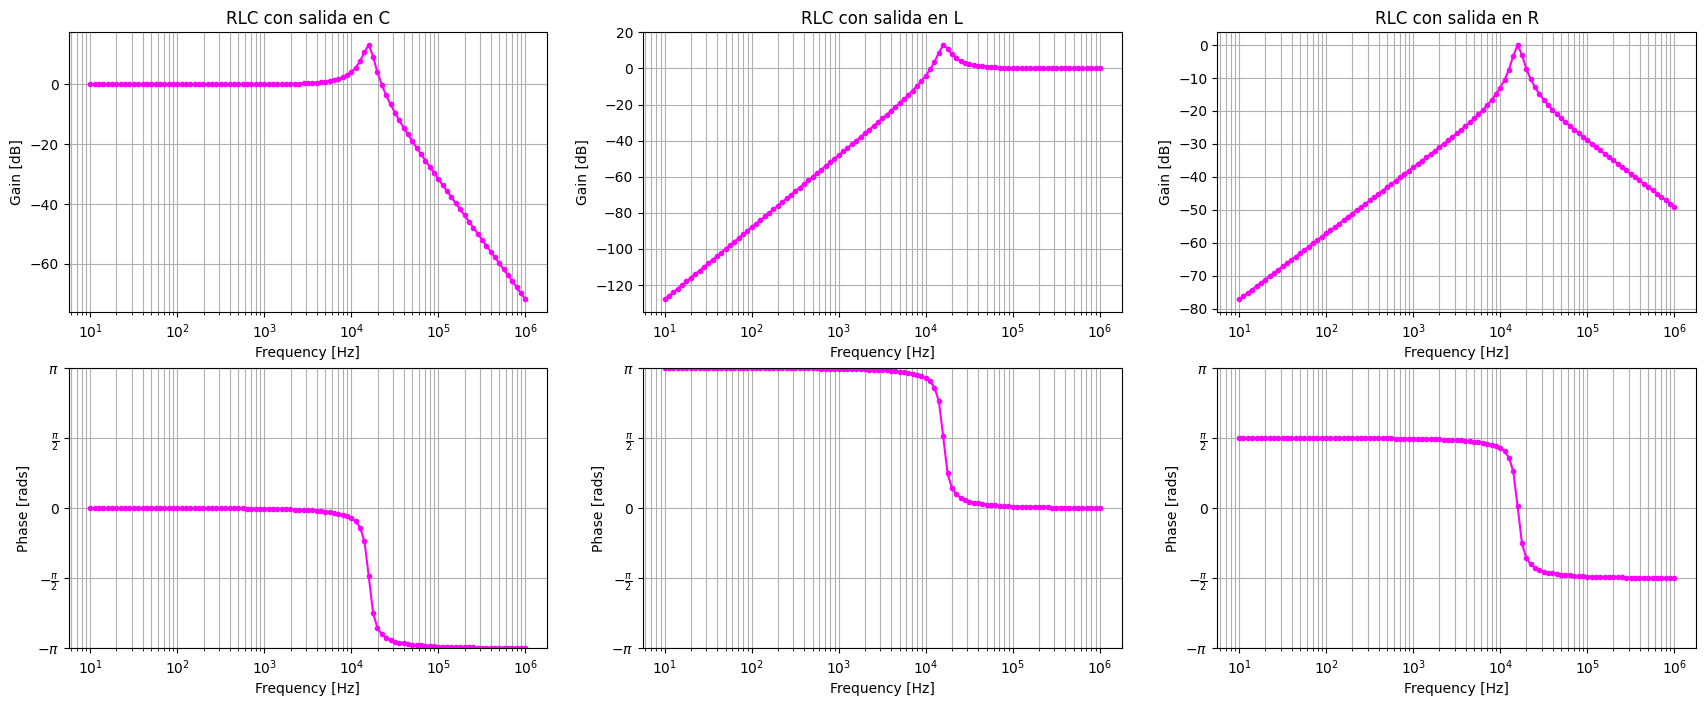

In [30]:
figure, axes = plt.subplots(2, 3, figsize=(21, 8))

# Circuito 1. RLC con salida en C
circuit = Circuit('RLC con salida en C')

# Se definen los elementos
source = circuit.SinusoidalVoltageSource(1, 'in', circuit.gnd, amplitude=10@u_V)
circuit.L(1, 'in', 1, 10@u_mH)
circuit.R(1, 1, 'out', 220@u_Ω)
circuit.C(1, 'out', circuit.gnd, 10@u_nF)

# Se simula y analiza el circuito
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.ac(start_frequency=10@u_Hz, stop_frequency=1@u_MHz, number_of_points=20,  variation='dec')

# Circuito 2. RLC con salida en L
circuit2 = Circuit('RLC con salida en L')

# Se definen los elementos
source2 = circuit2.SinusoidalVoltageSource(1, 'in', circuit.gnd, amplitude=10@u_V)
circuit2.C(1, 'in', 1, 10@u_nF)
circuit2.R(1, 1, 'out', 220@u_Ω)
circuit2.L(1, 'out', circuit.gnd, 10@u_mH)

# Se simula y analiza el circuito
simulator2 = circuit2.simulator(temperature=25, nominal_temperature=25)
analysis2 = simulator2.ac(start_frequency=10@u_Hz, stop_frequency=1@u_MHz, number_of_points=20,  variation='dec')

# Circuito 3. RLC con salida en R
circuit3 = Circuit('RLC con salida en R')

# Se definen los elementos
source3 = circuit3.SinusoidalVoltageSource(1, 'in', circuit.gnd, amplitude=10@u_V)
circuit3.C(1, 'in', 1, 10@u_nF)
circuit3.L(1, 1, 'out', 10@u_mH)
circuit3.R(1, 'out', circuit.gnd, 220@u_Ω)

# Se simula y analiza el circuito
simulator3 = circuit3.simulator(temperature=25, nominal_temperature=25)
analysis3 = simulator3.ac(start_frequency=10@u_Hz, stop_frequency=1@u_MHz, number_of_points=20,  variation='dec')

# Se realizan los diagramas de Bode para los circuitos
bode_diagram(axes=(axes[0,0],axes[1,0]),
             frequency=analysis.frequency,
             gain=20*np.log10(np.absolute(analysis['out'])),
             phase=np.angle(analysis['out'], deg=False),
             marker='.',
             color='magenta',
             linestyle='-'
            )
axes[0,0].set_title('RLC con salida en C')

bode_diagram(axes=(axes[0,1],axes[1,1]),
             frequency=analysis2.frequency,
             gain=20*np.log10(np.absolute(analysis2['out'])),
             phase=np.angle(analysis2['out'], deg=False),
             marker='.',
             color='magenta',
             linestyle='-'
            )
axes[0,1].set_title('RLC con salida en L')

bode_diagram(axes=(axes[0,2],axes[1,2]),
             frequency=analysis3.frequency,
             gain=20*np.log10(np.absolute(analysis3['out'])),
             phase=np.angle(analysis3['out'], deg=False),
             marker='.',
             color='magenta',
             linestyle='-'
            )
axes[0,2].set_title('RLC con salida en R')
axes[1,0].set_ylim(-np.pi, np.pi)
axes[1,0].set_yticks(np.linspace(-np.pi, np.pi, 5))
axes[1,0].set_yticklabels(axes[1,2].get_yticklabels())
axes[1,1].set_ylim(-np.pi, np.pi)
axes[1,1].set_yticks(np.linspace(-np.pi, np.pi, 5))
axes[1,1].set_yticklabels(axes[1,2].get_yticklabels())

Voltaje de salida en R, L y C de un circuito RLC

In [24]:
# Plot interactivo
def plot(freqC, freqL):
    global figure
    figure, (ax, ax2) = plt.subplots(2, 1, figsize=(7, 10))

    # Circuito 1. RLC con salida en C
    circuit = Circuit('RLC con salida en C')

    # Se definen los elementos
    source = circuit.SinusoidalVoltageSource(1, 'in', circuit.gnd, amplitude=10@u_V, frequency=freqC@u_kHz)
    circuit.L(1, 'in', 1, 10@u_mH)
    circuit.R(1, 1, 'out', 220@u_Ω)
    circuit.C(1, 'out', circuit.gnd, 10@u_nF)
    
    # Se simula y analiza el circuito
    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    analysis = simulator.transient(step_time=source.period/200, end_time=source.period*2)

    # Gráfica
    ax.set_title('RLC con salida en C')
    ax.set_xlabel('Tiempo [ms]')
    ax.set_ylabel('Voltaje [V]')
    ax.grid()
    ax.plot(analysis.time*1000, analysis['in'])
    ax.plot(analysis.time*1000, analysis['out'])
    ax.legend(('input', 'output'), loc=(.05,.1))
    ax.set_ylim(float(-source.amplitude*5), float(source.amplitude*5))

    # Circuito 2. RLC con salida en L
    circuit2 = Circuit('RLC con salida en L')

    # Se definen los elementos
    source2 = circuit2.SinusoidalVoltageSource(1, 'in', circuit.gnd, amplitude=10@u_V, frequency=freqL@u_kHz)
    circuit2.C(1, 'in', 1, 10@u_nF)
    circuit2.R(1, 1, 'out', 220@u_Ω)
    circuit2.L(1, 'out', circuit.gnd, 10@u_mH)

    # Se simula y analiza el circuito
    simulator2 = circuit2.simulator(temperature=25, nominal_temperature=25)
    analysis2 = simulator2.transient(step_time=source2.period/200, end_time=source2.period*2)

    # Gráfica
    ax2.set_title('RLC con salida en L')
    ax2.set_xlabel('Tiempo [ms]')
    ax2.set_ylabel('Voltaje [V]')
    ax2.grid()
    ax2.plot(analysis2.time*1000, analysis2['in'])
    ax2.plot(analysis2.time*1000, analysis2['out'])
    ax2.legend(('input', 'output'), loc=(.05,.1))
    ax2.set_ylim(float(-source.amplitude*5), float(source.amplitude*5))

# Slider frecuencia del circuito 1
sliderC = widgets.FloatSlider(
    value=15, 
    min=1, 
    max=25, 
    step=0.01,
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(width='500px')
)
# Slider frecuencia del circuito 2
sliderL = widgets.FloatSlider(
    value=15, 
    min=5, 
    max=35, 
    step=0.01,
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(width='500px')
)

# Llama al plot y los sliders
interact(plot, freqC=sliderC, freqL=sliderL)

# Llama a la caja de texto y el botón de guardar imagen
display(Text, button)

interactive(children=(FloatSlider(value=15.0, description='freqC', layout=Layout(width='500px'), max=25.0, min…

Text(value='', description='Nombre de la imagen:', style=TextStyle(description_width='initial'))

Button(description='Guardar imagen', style=ButtonStyle())

In [23]:
# Plot interactivo
def plot(freqR):
    global figure
    figure, ax = plt.subplots(figsize=(7, 4))

    # RLC con salida en R
    circuit = Circuit('RLC con salida en R')

    # Se definen los elementos
    source = circuit.SinusoidalVoltageSource(1, 'in', circuit.gnd, amplitude=10@u_V, frequency=freqR@u_kHz)
    circuit.C(1, 'in', 1, 10@u_nF)
    circuit.L(1, 1, 'out', 10@u_mH)
    circuit.R(1, 'out', circuit.gnd, 220@u_Ω)
    
    # Se simula y analiza el circuito
    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    analysis = simulator.transient(step_time=source.period/200, end_time=source.period*2)

    # Gráfica
    ax.set_title('RLC con salida en R')
    ax.set_xlabel('Tiempo [ms]')
    ax.set_ylabel('Voltaje [V]')
    ax.grid()
    ax.plot(analysis.time*1000, analysis['in'])
    ax.plot(analysis.time*1000, analysis['out'])
    ax.legend(('input', 'output'), loc=(.05,.1))
    ax.set_ylim(float(-source.amplitude*5), float(source.amplitude*5))

# Slider frecuencia
sliderR = widgets.FloatSlider(
    value=15, 
    min=6, 
    max=25, 
    step=0.01,
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(width='500px')
)

# Llama al plot y los sliders
interact(plot, freqR=sliderR)

# Llama a la caja de texto y el botón de guardar imagen
display(Text, button)

interactive(children=(FloatSlider(value=15.0, description='freqR', layout=Layout(width='500px'), max=25.0, min…

Text(value='', description='Nombre de la imagen:', style=TextStyle(description_width='initial'))

Button(description='Guardar imagen', style=ButtonStyle())